# Content Moderation on Craigslist Discussion Forums

The comments are from Religion Sub Forum

# Importing Data

In [1]:
## Data has been scraped from Craigslist Website and has been manually labelled to Hate Comment or Not

In [1]:
# importing os to change Current Working Directory
import os
os.chdir("D:/OneDrive - purdue.edu/BAIM/Module 4/Unstructured Data/Assignments/Team/")

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
# from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

from autocorrect import Speller
# from hatesonar import Sonar
from transformers import pipeline
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras.layers import Input, Dense

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


from sklearn.metrics import roc_auc_score


# read to input file to pandas dataframe

Input_Data = pd.read_csv('Data/Comments.csv')

# replacing some random symbols in the data
Input_Data['Title & Comments'] = Input_Data['Title & Comments'].replace(["�","'"],[" ", ""], regex =True)
print("Data Strcutre is", Input_Data.head())

Data Strcutre is                                     Title & Comments  Hate_or_not
0                             that covers part of it            0
1  The NIV stinks, Trump did what he was supposed...            1
2  no man is perfect, especially one in politics ...            0
3  he served his masters well, think of volley ba...            0
4                                 Ha ha, trumpsters.            0


In [2]:
# Function to clean data: Tokenization, Autocorrect spelling Words, Lemmatization, Removal of Stop Words and Punctuatons

def clean_data(doc):
    token = nltk.word_tokenize(doc)
    spell = Speller(lang='en')
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(spell(token.lower())) for token in token if token.isalpha() if token not in stopwords.words('english')]
    return  lemmatized

In [3]:
# Running the above function to Clean the data

i = 0
Input_Data['Cleaned_Data'] = ""
while i < len(Input_Data.index):
    Input_Data['Cleaned_Data'][i] = clean_data(Input_Data['Title & Comments'][i])
    i = i+1

In [4]:
#Checking the Cleaned Data

print("Structure of Cleaned Data is" )
Input_Data['Cleaned_Data'].head()

Structure of Cleaned Data is


0                                        [cover, part]
1    [the, niv, stick, trump, supposed, mission, ac...
2    [man, perfect, especially, one, politics, trum...
3    [served, master, well, think, volley, ball, on...
4                                  [ha, ha, trumpeter]
Name: Cleaned_Data, dtype: object

# Topic Modelling

In [5]:
# Creatng a custom tokenizer which returns the same text
def tokenize(text):
    return text

# Creating an instance of CountVectorizer with min_df 3, 
# created n grams 1 & 2, removed any extra stop words
Vectorizer = CountVectorizer(tokenizer = tokenize, min_df = 3, ngram_range = (1,2),lowercase=False, stop_words='english')

# Fitting and transforming the above Vectorizer on the Cleaned Comments data
Term_Document_Matrix = Vectorizer.fit_transform(Input_Data['Cleaned_Data']).toarray()

# checking if the Vectorizer worked properly
print("Term Document Matrix shape, max and sum are")
print(Term_Document_Matrix.shape)
print(np.amax(Term_Document_Matrix))
print(np.sum(Term_Document_Matrix))

Term Document Matrix shape, max and sum are
(1161, 793)
23
5564


In [6]:
# Creating an instance of LDA Decompositor with 5 topics and using 
# a random state to get same results every time I run
lda = LatentDirichletAllocation(n_components=5, random_state = 0 ).fit(Term_Document_Matrix)
 
# Transforming the Term Document to Probability densities of Topics
Topic_Matrix = list(lda.transform(Term_Document_Matrix))


# Convert the Topic Matrix to DataFrame and pull out the topic with highest probability 
# for each document and then find the topic wise distribution 
Counts = pd.DataFrame(Topic_Matrix).idxmax(axis = 1).value_counts()

# Looping through the Counts to print the Topic Distribution
print("Topic Distribution is")
i = 0
while i < 5:
    print("Topic", i,":",Counts[i] )
    i = i+1
    
# Getting the names of the features
terms = Vectorizer.get_feature_names()

# Looping the through the topics in the reviews dataset 
# and printing the top words in each topic
print("Top 5 Words in the 5 topics are: ")
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx))
    print(" ".join([terms[i] for i in topic.argsort()[:-5-1:-1]]))

Topic Distribution is
Topic 0 : 278
Topic 1 : 214
Topic 2 : 215
Topic 3 : 211
Topic 4 : 243
Top 5 Words in the 5 topics are: 
Topic 0:
white ha black say u
Topic 1:
know lol inherit forever righteous
Topic 2:
god dont yes people like
Topic 3:
good people morning day thing
Topic 4:
im like christian forum religion


Four Topics looks like, they are related to Religio, But the first one has words related to Race

Now lets further deep dive into the Data and see the word clouds created from the words 

# Word Clouds

In [7]:
# Creating data for Comprehensive Word Cloud
words_complete = [j for i in Input_Data['Cleaned_Data'] for j in i]

# Creating data for Normal comment's Word Cloud
words_normal = [j for i in Input_Data[Input_Data['Hate_or_not']==0]['Cleaned_Data'] for j in i]

# Creating data for Hate comment's Word Cloud
words_hate = [j for i in Input_Data[Input_Data['Hate_or_not']==1]['Cleaned_Data'] for j in i]

Comprehensive World Cloud


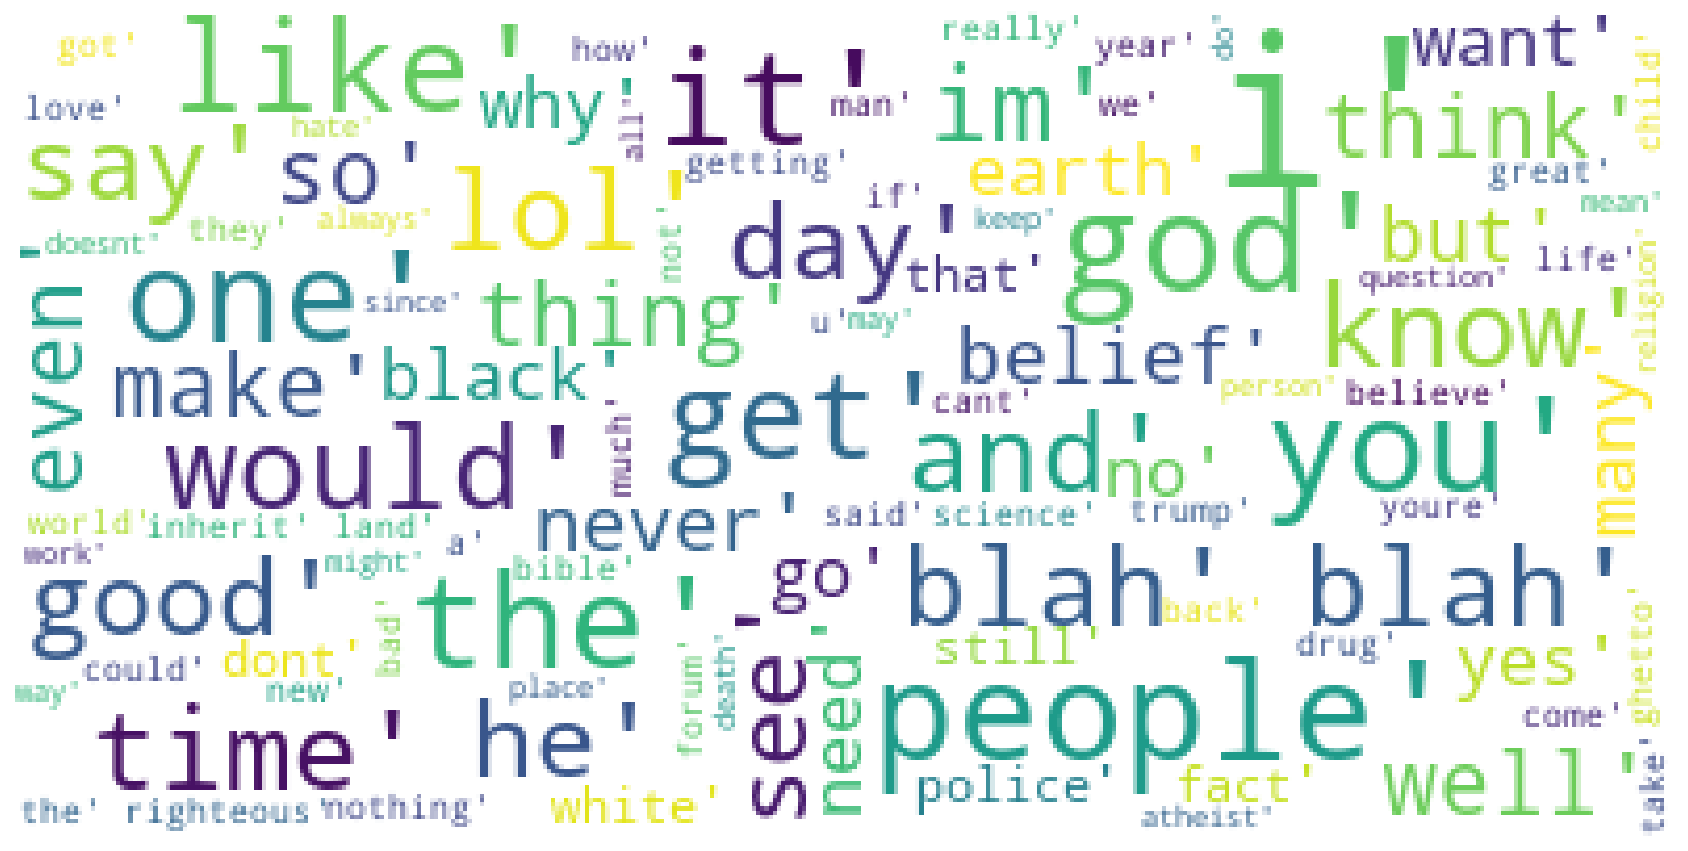

In [9]:
# Creating an instance of WordCloud for comprehensive Word Cloud 
wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      max_font_size=50, 
                      random_state=42
                      ).generate(str(words_complete))

# Printing the Comprehensive Word Cloud
print("Comprehensive World Cloud")
print(wordcloud)
fig = plt.figure(1, figsize= (30,30) )
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Comprehensive Word Cloud looks normal

Hate Comment's World Cloud


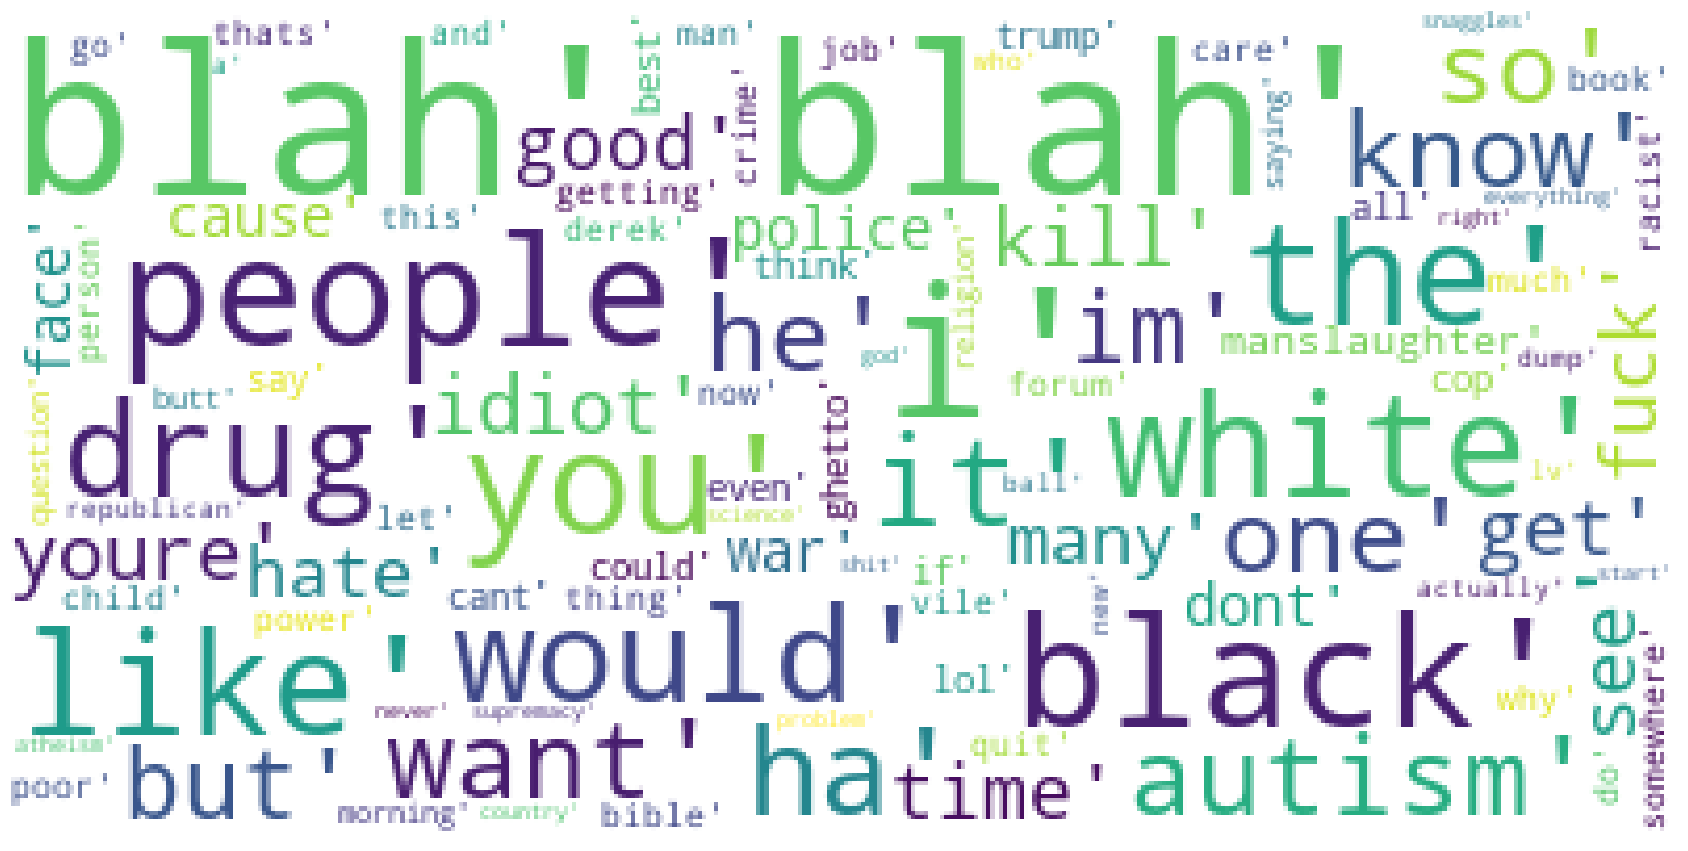

In [11]:
# Creating an instance of WordCloud for Hate Comment's Word Cloud 
wordcloud_hate = WordCloud(background_color='white',
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(words_hate))
# Printing the Hate Comment's Word Cloud
print("Hate Comment's World Cloud")
print(wordcloud_hate)
fig = plt.figure(1, figsize= (30,30) )
plt.imshow(wordcloud_hate)
plt.axis('off')
plt.show()

Word Cloud from hate comments show words related to race and also some profane words

Normal Comment's World Cloud


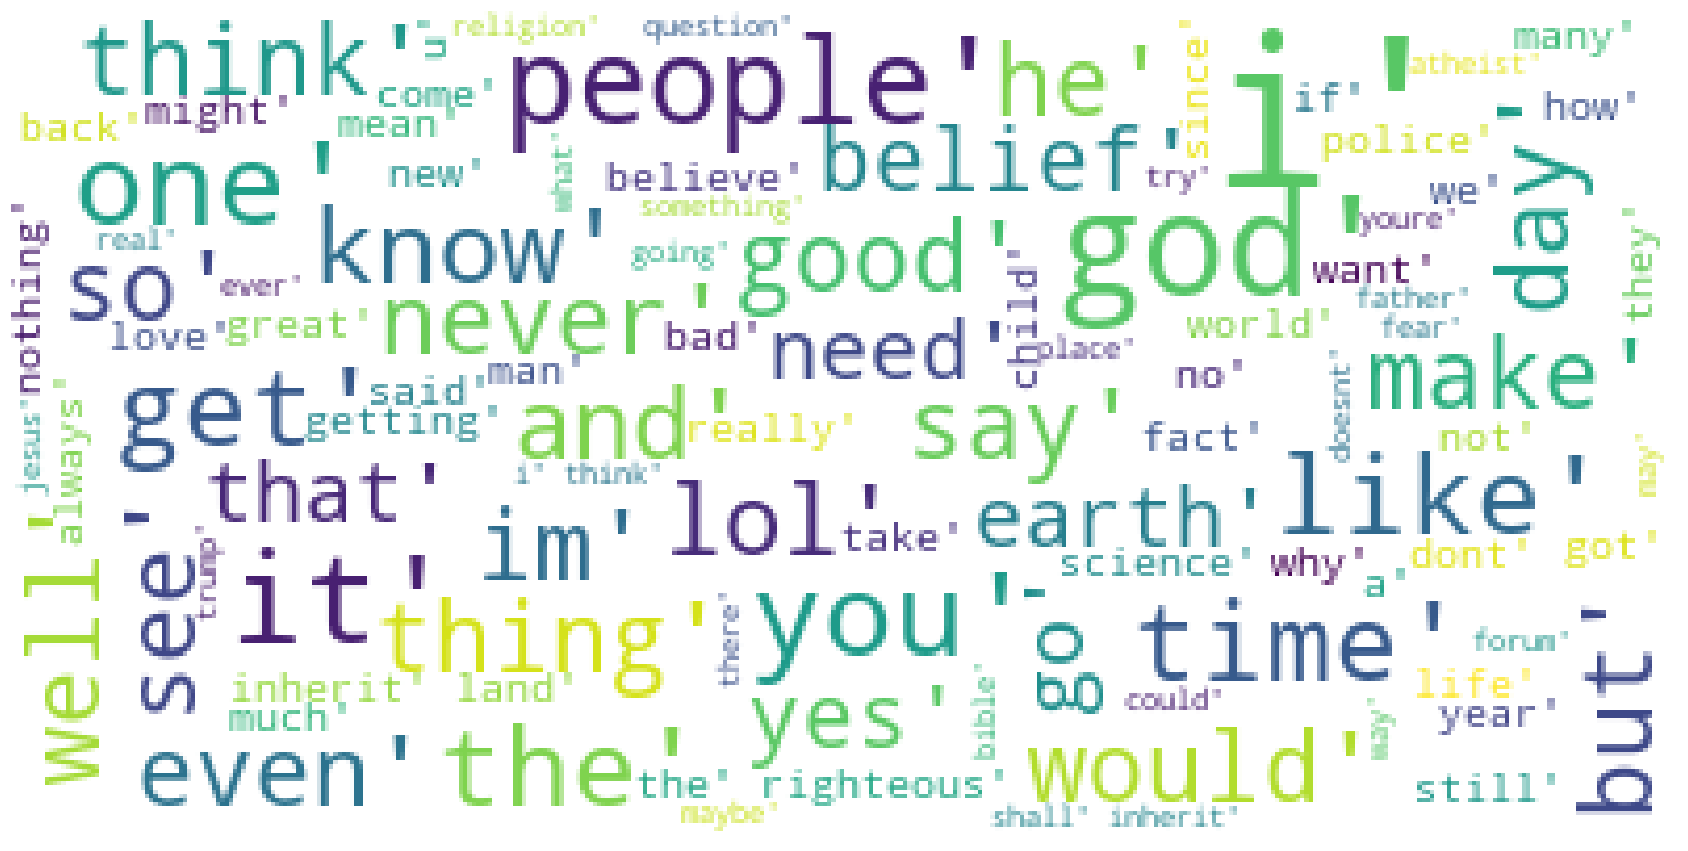

In [12]:
# Creating an instance of WordCloud for Normal Comment's Word Cloud 
wordcloud_nrm = WordCloud(background_color='white',
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(words_normal))

# Printing the Normal Comment's Word Cloud
print("Normal Comment's World Cloud")
print(wordcloud_nrm)
fig = plt.figure(1, figsize= (30,30) )
plt.imshow(wordcloud_nrm)
plt.axis('off')
plt.show()

Again the Normal comments word cloud resemble the theme of the forum - Religion

# BERT Encoded Models

Converting the Words to higher dimensions so as to get semantic meaning for the words averaged to documents 

In [13]:
# Creating an instance of BERT Tokenizer which can be used to create input for extracting the Word Embeddings

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Creating an instance of the pre-trained deep learning model 
model = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [14]:
# Looping through the documents, Tokenizing, extracting the 
# word embedding for each word and then averaging the vectors
# to get a single vector for each document 
i = 0
Input_Data['Emmbedding'] = ""
while i < len(Input_Data.index):
    Input_Data['Emmbedding'][i] = np.array(model(tokenizer(Input_Data['Title & Comments'][i], return_tensors='np'))[0]).mean(axis = 1).flatten()
    i = i+1

Let us checking if we can predict if a comment is a Hate Comment or not

In [15]:
# Splitting the Embedding words and creating separate columns for each higher dimension and saving it in a dataframe
X = pd.DataFrame(Input_Data['Emmbedding'].tolist())
y = Input_Data['Hate_or_not']

# Splitting the data into train and test with 75% allocated for training data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

In [16]:
# Logit Model
Logitmodel = LogisticRegression()

# Logit Model training
Logitmodel.fit(X_train, y_train)
y_pred_logit = Logitmodel.predict(X_test)

# Logit Model evaluation
roc_auc_score_logit = roc_auc_score(y_test, y_pred_logit)
print("Logit model test roc_auc_score:: {:.2f}%".format(roc_auc_score_logit*100))


# SVM Model
SVMmodel = LinearSVC()

# SVM Model training
SVMmodel.fit(X_train, y_train)
y_pred_SVM = SVMmodel.predict(X_test)

# SVM Model evaluation
roc_auc_score_svm = roc_auc_score(y_test, y_pred_SVM)
print("SVM model roc_auc_score:: {:.2f}%".format(roc_auc_score_svm*100))


# Decison Tree And Random Forest
DTmodel = DecisionTreeClassifier()
RFmodel = RandomForestClassifier(n_estimators = 300, #Trees in => Inc Accuracy
                                 max_depth=20, #Maximum depth of the tree
                                 bootstrap=True, #Pick different samples
                                 random_state=0) #Fix random state         

# Decison Tree training
DTmodel.fit(X_train, y_train)
y_pred_DT = DTmodel.predict(X_test)

# Decison Tree evaluation
roc_auc_score_DT = roc_auc_score(y_test, y_pred_DT)
print("DT model roc_auc_score:: {:.2f}%".format(roc_auc_score_DT*100))

# Random Forest training
RFmodel.fit(X_train, y_train)
y_pred_RF = RFmodel.predict(X_test)

# Random Forest evaluation
roc_auc_score_RF = roc_auc_score(y_test, y_pred_RF)
print("RF model roc_auc_score:: {:.2f}%".format(roc_auc_score_RF*100))

# LightGBM
LGBmodel = LGBMClassifier(objective= 'binary', metric = 'auc', subsample = 1, num_leaves = 200, num_iterations =500, learning_rate = 0.1,  random_state=0 )

# training
LGBmodel.fit(X_train, y_train)
y_pred_LGB = LGBmodel.predict(X_test)

# evaluation
roc_auc_score_LGB = roc_auc_score(y_test, y_pred_LGB)
print("LGB model roc_auc_score:: {:.2f}%".format(roc_auc_score_LGB*100))

Logit model test roc_auc_score:: 65.69%
SVM model roc_auc_score:: 70.37%
DT model roc_auc_score:: 59.16%
RF model roc_auc_score:: 55.23%
LGB model roc_auc_score:: 61.61%


Classic Models gave us an Test Area under ROC of ~0.7. Let us further try out a Neural Network to check the performance 

In [29]:
# Neural Network

# Number of features to input
num_features = len(X_train.columns) 

# ANN with Keras
np.random.seed(10)

# Initialising the ANN
classifier = tf.keras.Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(20, activation = 'relu', input_dim = num_features)) 

# Adding the second hidden layer
classifier.add(Dense(20,  activation = 'relu'))

# Adding the output layer
classifier.add(Dense(1,  activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy')

# Neural Network Training
classifier.fit(X_train, y_train, batch_size = 10, epochs = 50, verbose=0 )
y_pred_NN = classifier.predict(X_test)

# Neural Network evaluation
roc_auc_score_NN = roc_auc_score(y_test, y_pred_NN)
print("NN model roc_auc_score:: {:.2f}%".format(roc_auc_score_NN*100))

NN model roc_auc_score:: 76.86%


A basic Neural Network using BERT Word Embeddings with just 1000 comments was able to detect Hate Comments gave an ROC of ~0.77